# Example 2 - Compute Curie depth
Tanaka *et al.* (1999) based their method upon an expression for the radial power spectrum that assumes random magnetisation of the crust, and a radially averaged power spectra $\Phi_{\Delta T}(|k|)$:

$$(1) \Phi_{\Delta T}(|k|)=Ae^{-2|k|Z_t}(1-e^{-|k|(Z_b-Z_t)})^2$$

where:
 - $k$ - spatial wavenumber ($k=2\pi/\lambda$, where $\lambda$ is wavelength).
 - $Z_t$ - top of assumed magnetic source.
 - $Z_b$ - bottom of assumed magnetic source.
 - ($Z_b-Z_t$ is hence the thickness of the magnetic source)

For wavelengths less than twice the source thickness, this simplifies to:

$$(2) \ln [\Phi_{\Delta T}(|k|)^{1/2}] = \ln B-|k|Z_t $$

where $B$ is another constant. Conversely, (1) can be rewritten, with $Z_o$ as the centroid depth of the magnetic source:

$$(3) \Phi_{\Delta T}(|k|)^{1/2} = Ce^{-|k|Z_o}(e^{-|k|(Z_t-Z_o)}-e^{-|k|(Z_b-Z_o)}) $$

For long wavelengths, where $2d$ is the magnetic source thickness:
$$(4) \Phi_{\Delta T}(|k|)^{1/2} = Ce^{-|k|Z_o}(e^{-|k|(-d)}-e^{-|k|(-d)})\approx Ce^{-|k|Z_o}2|k|d $$

$$ \ln \{\Phi_{\Delta T}(|k|)^{1/2}/|k|\}=\ln D-|k|Z_o  $$


Estimates of $Z_t$ and $Z_o$ can be estimated from Equations (2) and (5), and hence the base of the magnetic source (assumed to be at the Curie point depth):

$$(6) Z_b=Z_o-(Z_t-Z_o) = 2Z_o-Z_t $$

### Contents

- [Plot radial power spectrum](#Plot-radial-power-spectrum)
- [Compute CPD Estimate](#Compute-cpd-estimate)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pycurious

In [2]:
nx, ny = 343, 268      # nodes of grid;
window_size = 400e3    # windows size;
x_distance=25e3        # x moving distance, or x resolution
y_distance=25e3        # y moving distance, or x resolution
input_filename="../../data/test_mag_data.txt"  # input data; a txt, inverse from grid;
output_filename="../../data/zb_3var.txt"   # result data file

In [3]:
# load x,y,anomaly
mag_data = np.loadtxt(input_filename)



x = mag_data[:,0]
y = mag_data[:,1]
# sometimes you need spesify a value when the spaceing is not idnetical.
nx=len(np.unique(x))   
ny=len(np.unique(y))
d = mag_data[:,2].reshape(ny,nx)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# initialise CurieOptimise object
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)

## Plot radial power spectrum
The radial power spectrum is computed from a square window of the magnetic anomaly. Methods to select window sizes and compute the Fast Fourier Transform (FFT) belong to the `CurieGrid` object. We apply the default `np.hanning` taper to the power spectrum as in [Ex1-Plot-power-spectrum](#./Ex1-Plot-power-spectrum.ipynb).

In [4]:

# pick the centroid
xpt = 0.5*(xmin + xmax)
ypt = 0.5*(ymin + ymax)

window_size = 200e3
subgrid = grid.subgrid(window_size, xpt, ypt)

Text(0,0.5,'$\\ln(\\Phi_{\\Delta T}(|k|)^{1/2})/(2\\pi)$')

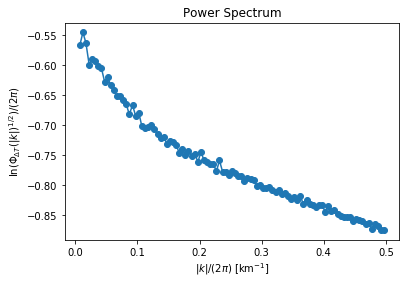

In [5]:
k, Phi, sigma_Phi = grid.radial_spectrum_log(subgrid, taper=None)

# Plot of power spectrum, as function of spatial frequency
plt.plot(k/(2*np.pi), Phi/(2*np.pi), '-o')
plt.title('Power Spectrum')
plt.xlabel(r'$|k|/(2\pi)$ [km$^{-1}$]')
plt.ylabel(r'$\ln(\Phi_{\Delta T}(|k|)^{1/2})/(2\pi)$')

Text(0,0.5,'$\\ln(\\Phi_{\\Delta T}(|k|)^{1/2}/|k|)/(2\\pi)$')

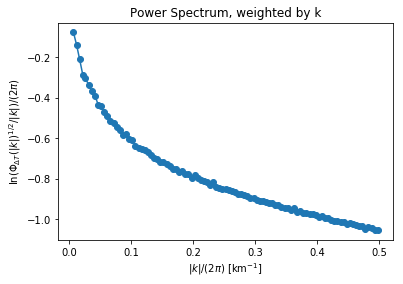

In [6]:
Phi_n = np.log(np.exp(Phi)/k)
plt.plot(k/(2*np.pi), Phi_n/(2*np.pi), '-o')
plt.title('Power Spectrum, weighted by k')
plt.xlabel(r'$|k|/(2\pi)$ [km$^{-1}$]')
plt.ylabel(r'$\ln(\Phi_{\Delta T}(|k|)^{1/2}/|k|)/(2\pi)$')

## Compute CPD Estimate
As described above, once the power spectrum (and weighted spectrum) are computed, then the gradient of linear fits of certain wavenumber/spatial frequency windows can be taken as estimates of $Z_t$ and $Z_o$. The weighted linear fitting of the respective spectral window is implemented in the `CurieGrid` parent class as `tanaka1999`, and takes the spectrum, wave number, and spectrum error as inputs. The function also has functionality to pass specific spectral windows for each spectra, however, the default is to consider spatial frequencies of 0.05 - 0.2 (recalling that $k$, the wavenumber, is proportional to the spatial frequency $\nu$ by $k=2\pi\nu$).


The function has two tuple returns: the gradient estimate, intercept and errors of $Z_t$ and $Z_o$. The gradient and errors can then be passed into the `CurieGrid.ComputeTanaka` method to obtain estimates of $Zb$ and $\varepsilon Zb$.

In [12]:
(zts,zti,ztr), (zos,zoi,zor) = grid.optimise_tanaka(k, Phi,  (0.2,0.4), (0.01,0.08))
#Zb, eZb = pycurious.ComputeTanaka(Ztr, dZtr, Zor, dZor)
print(2*zos-zts)
print(zos,zts)

11.022663180944114
5.720435522791847 0.4182078646395807


Text(0,0.5,'$\\ln(\\Phi_{\\Delta T}(|k|)^{1/2}/|k|)/(2\\pi)$')

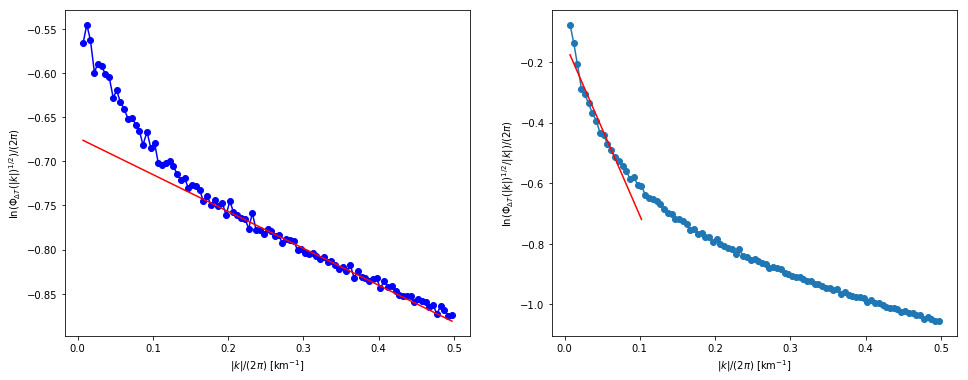

In [13]:
# make two plots with Z-lines overlain.
# Plot of power spectrum, as function of spatial frequency
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6),)

ax1.plot(k/(2*np.pi), Phi/(2*np.pi), '-bo', (k/(2*np.pi))[0:100], (-zts*k/(2*np.pi)+zti)[0:100],'r-')
#ax1.title('Power Spectrum')
ax1.set_xlabel(r'$|k|/(2\pi)$ [km$^{-1}$]')
ax1.set_ylabel(r'$\ln(\Phi_{\Delta T}(|k|)^{1/2})/(2\pi)$')

ax2.plot(k/(2*np.pi), Phi_n/(2*np.pi), '-o',(k/(2*np.pi))[0:20],(-zos*k/(2*np.pi)+zoi)[0:20],'r-')
ax2.set_xlabel(r'$|k|/(2\pi)$ [km$^{-1}$]')
ax2.set_ylabel(r'$\ln(\Phi_{\Delta T}(|k|)^{1/2}/|k|)/(2\pi)$')
